In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image, ImageFile
import tensorflow as tf
import json
import glob
import random

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import gradio as gr
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import pathlib
dataset_path = "/content/train"
train_data_dir = pathlib.Path(dataset_path + "/images")
test_data_dir = pathlib.Path("/content/test/images")

train_files = glob.glob(r"" + dataset_path + "/images/*.png")
train_files = list(filter(lambda x: "post" in x, train_files))
train_files = random.sample(train_files, 1500)
train_datasize = len(train_files)
print("Training data:", train_datasize)

test_files = glob.glob(r"" + "/content/test/images/*.png")
test_files = list(filter(lambda x: "post" in x, test_files))
test_files = random.sample(test_files, 500)
test_datasize = len(test_files)
print("Test data:", test_datasize)


Training data: 1500
Test data: 500


In [ ]:
images = list(train_data_dir.glob('*'))
random_image = random.choice(images)
im = PIL.Image.open(str(random_image))

width, height = im.size
print(width)
print(height)
im.resize((300, 300)).show()

1024
1024


In [ ]:
img_height = 1024
img_width = 1024
class_names = np.array(sorted(['volcano', 'flooding', 'earthquake', 'fire', 'wind', 'tsunami']))
print(class_names)

['earthquake' 'fire' 'flooding' 'tsunami' 'volcano' 'wind']


In [ ]:
def get_label(file_path, type):
    parts = file_path.split('/')
    path = dataset_path + '/labels/'
    if type == "test":
        path = '/content/test/labels/'
    f = open(path + parts[-1].split('.')[0] + '.json')
    data = json.load(f)
    disaster_type = data['metadata']['disaster_type']
    f.close()

    label = disaster_type == class_names
    one_hot = np.zeros(len(class_names), dtype=np.uint8)
    one_hot[label] = 1

    return one_hot

def get_label_from_one_hot(array):
    return class_names[np.where(array == 1)]

In [ ]:
train_X = np.zeros((train_datasize, img_height, img_width, 3), dtype=np.uint8)
train_Y = np.zeros((train_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(train_files)):
    img = PIL.Image.open(train_files[i])
    train_X[i] = np.array(img)
    train_Y[i] = get_label(train_files[i], "train")
print("Train")
print(train_X.shape)
print(train_Y.shape)

test_X = np.zeros((test_datasize, img_height, img_width, 3), dtype=np.uint8)
test_Y = np.zeros((test_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(test_files)):
    img = PIL.Image.open(test_files[i])
    test_X[i] = np.array(img)
    test_Y[i] = get_label(test_files[i], "test")
print("Test")
print(test_X.shape)
print(test_Y.shape)

Train
(1500, 1024, 1024, 3)
(1500, 6)
Test
(500, 1024, 1024, 3)
(500, 6)


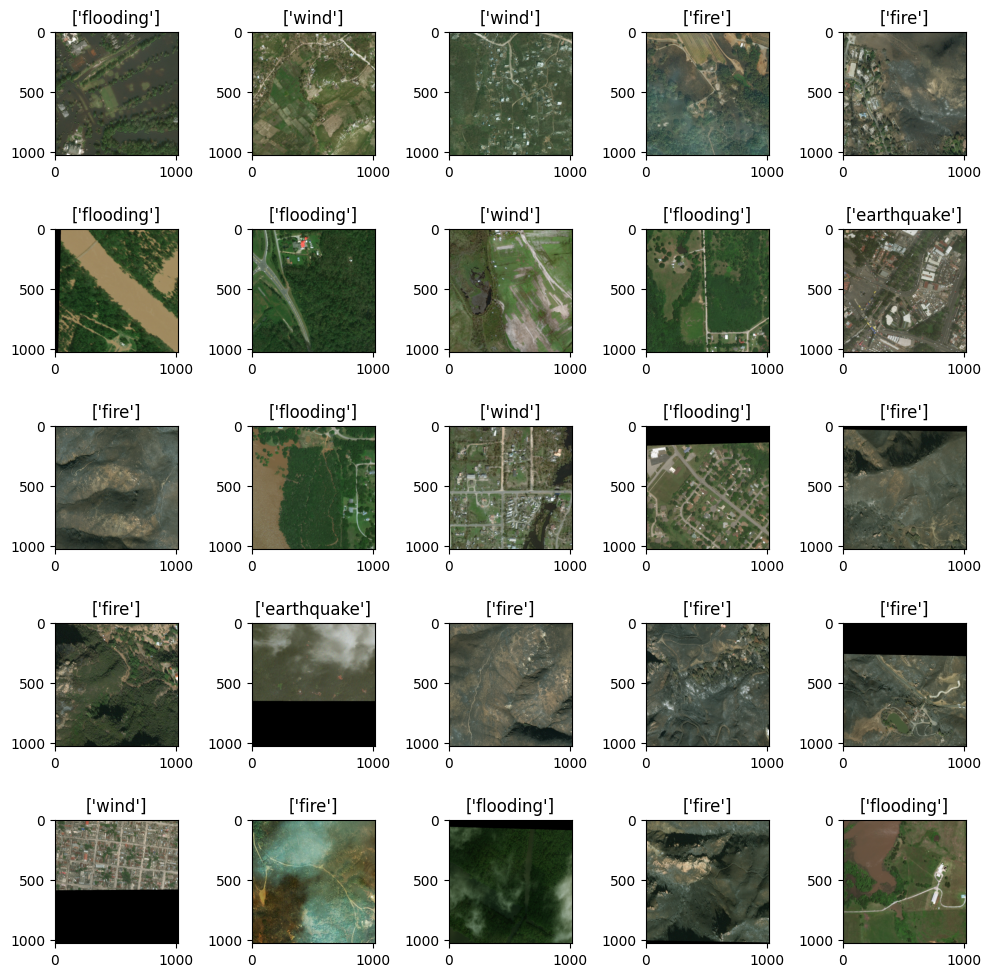

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    choice = random.randint(0, train_datasize - 1)
    plt.title(get_label_from_one_hot(train_Y[choice]))
    plt.imshow(train_X[choice])

plt.tight_layout()
plt.show()


In [ ]:
# Load the DenseNet121 model, exclude the top layers (pre-trained on ImageNet)
base_model = DenseNet121(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze the base model

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 32, 32, 1024)      7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 batch_normalization_1 (Bat  (None, 128)               5

In [ ]:
epochs = 10
batch_size = 16

history = model.fit(
    train_X, train_Y,
    validation_data=(test_X, test_Y),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/10
94/94 [==============================] - 812s 9s/step - loss: 4.4265 - accuracy: 0.3153 - val_loss: 3.3126 - val_accuracy: 0.6260
Epoch 2/10
94/94 [==============================] - 832s 9s/step - loss: 3.5147 - accuracy: 0.5147 - val_loss: 2.8474 - val_accuracy: 0.7180
Epoch 3/10
94/94 [==============================] - 851s 9s/step - loss: 3.1082 - accuracy: 0.5933 - val_loss: 2.5436 - val_accuracy: 0.8000
Epoch 4/10
94/94 [==============================] - 854s 9s/step - loss: 2.8648 - accuracy: 0.6493 - val_loss: 2.3023 - val_accuracy: 0.8380
Epoch 5/10
94/94 [==============================] - 850s 9s/step - loss: 2.6181 - accuracy: 0.6827 - val_loss: 2.1329 - val_accuracy: 0.8560
Epoch 6/10
94/94 [==============================] - 847s 9s/step - loss: 2.4532 - accuracy: 0.7213 - val_loss: 1.9912 - val_accuracy: 0.8660
Epoch 7/10
94/94 [==============================] - 857s 9s/step - loss: 2.3553 - accuracy: 0.7360 - val_loss: 1.8783 - val_accuracy: 0.8860
Epoch 8/10
94

In [ ]:
# Model Evaluation and Metrics Calculation
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_Y, axis=1)

16/16 [==============================] - 219s 14s/step


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9100


In [ ]:
# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

  earthquake       0.88      0.88      0.88        16
        fire       0.94      0.96      0.95       208
    flooding       0.92      0.95      0.93       166
     tsunami       0.83      0.83      0.83        18
     volcano       0.00      0.00      0.00         3
        wind       0.84      0.79      0.81        89

    accuracy                           0.91       500
   macro avg       0.73      0.73      0.73       500
weighted avg       0.90      0.91      0.91       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 14   1   1   0   0   0]
 [  2 199   2   3   0   2]
 [  0   1 157   0   0   8]
 [  0   2   1  15   0   0]
 [  0   0   0   0   0   3]
 [  0   9  10   0   0  70]]


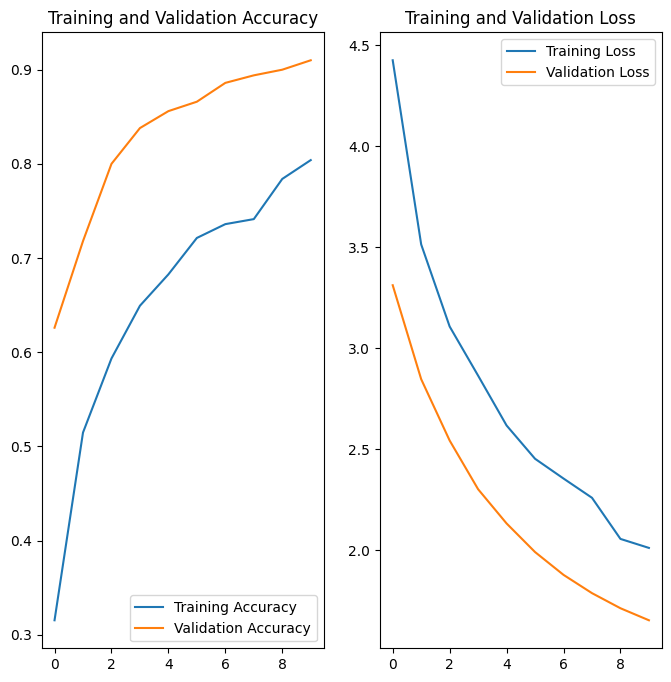

In [ ]:
# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Saving the model
model.save("disaster-classification-model")

In [ ]:
# Gradio Interface for Inference
def disaster_classification(img):
    img_resized = np.array(Image.fromarray(img).resize((img_height, img_width)))
    image = np.zeros((1, img_height, img_width, 3), dtype=np.uint8)
    image[0] = img_resized
    prediction = model.predict(image).tolist()[0]
    return {class_names[i]: prediction[i] for i in range(len(class_names))}

iface = gr.Interface(
    fn=disaster_classification,
    inputs=gr.Image(image_mode='RGB', type='numpy'),
    outputs=gr.Label()
)

iface.launch(share=True, show_error=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://6c61a72878c4632821.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 497ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://6c61a72878c4632821.gradio.live
